# Spaceship Titanic
The project inspects Spaceship Titanic Dataset from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable Transported prediction. 

Transported predictions will apploaded to Kaggle as a compatition entry, performance goal is 79% accuracy.

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/overview).

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import missingno as msno

from imblearn.over_sampling import SMOTE
import joblib

from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer

import warnings
from sklearn.exceptions import UndefinedMetricWarning


pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data download and Cleaning
Checking for duplicates and empty values, as well as the size of dataset:

* Dataset has 8693 observations and 14 features
* Some features are missing 2% of their data
* No duplicates

In [122]:
titanic = help_tool.csv_download(r'Archive\spaceship-titanic\train.csv')
help_tool.first_look(titanic)

Dataset has 8693 observations and 14 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.0
HomePlanet,object,201,2.3
CryoSleep,object,217,2.5
Cabin,object,199,2.3
Destination,object,182,2.1
Age,float64,179,2.1
VIP,object,203,2.3
RoomService,float64,181,2.1
FoodCourt,float64,183,2.1
ShoppingMall,float64,208,2.4


# Feature separation and Cleaning
Features are cast into groups, depending on their properties.

In [123]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
continuous_features = ['Age', 'Group', 'Deck_num'] + amenities
category_features = ['HomePlanet', 'Destination', 'Deck', 'Group_Id']
binary_features = ['CryoSleep', 'VIP', 'Transported']

## Feature Splitting
Some columns have multitude of information encoded:
* PassengerId - Group and Group_Id
* Cabin: 
    * Deck - values A:G, T will be converted to integers 1-6. T is an unconventional deck name, thus unconventional -1 was assigned to it.
    * Deck_num -  
    * Side - has only 2 values S (Starboard) and P (Port), will be made to bool feature.

These features will be separeted.

In [124]:
def cleaning(df):
    # Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    df[['Group', 'Group_Id']] = df['PassengerId'].str.split('_', expand=True)


    # Form deck/num/side, where side can be either P for Port or S for Starboard.
    df[['Deck', 'Deck_num', 'Side']] = df['Cabin'].str.split('/', expand=True)

    # Available Deck values are A-G, T
    df['Deck'] = df['Deck'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': -1})

    # Side has only 2 values and will be updated to bool feature
    df.loc[df['Side'] == 'S', 'Side_S'] = 1
    df.loc[df['Side'] == 'P', 'Side_S'] = 0


    # Separating last name for family identifications
    df[['First_Name', 'Last_Name']] = df['Name'].str.split(' ', expand=True)

    
    for feature in binary_features + ['Group', 'Group_Id', 'Deck_num']:
        try:
            titanic[feature] = titanic[feature].astype(int)
        except: 
            titanic[feature] = titanic[feature].astype(float)


    df.drop(columns=['PassengerId', 'Name', 'Side'], inplace=True)
    return df

titanic = cleaning(titanic)

In [125]:
binary_features = binary_features + ['Side_S']

## Feature Cleaning
### CryoSleep
Passengers in cryosleep are confined to their cabins, yet some of amenities values are missing. These values can be filled in with 0 (money spent).

In [126]:
titanic[titanic['CryoSleep'] == 1][amenities].isna().sum()

RoomService     68
FoodCourt       70
ShoppingMall    96
Spa             65
VRDeck          62
dtype: int64

Passangers that CryoSleep spend 0 money on amenities.

In [127]:
titanic[titanic['CryoSleep'] == 1][amenities].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

In [91]:
condition = titanic['CryoSleep'] == 1
titanic.loc[condition, amenities] = titanic.loc[condition, amenities].fillna(0)

### Missing HomePlanet, Cabin, Destination
People in a group are often family members, but not always. For example, last name Acobsond is share by people in different groups.

In [129]:
titanic[['Group', 'Last_Name']].value_counts().to_frame().reset_index().rename(columns={0: 'Count'}).sort_values(by='Last_Name').head()

,Group,Last_Name,Count
165,6905,Acobson,3
5155,4220,Acobson,1
4921,991,Acobsond,1
4210,2220,Acobsond,1
2212,5671,Acobsond,1


In [132]:
def missing_value(df, feature):
    df.sort_values(['Last_Name', 'Group', feature], inplace=True)
    groups = df.groupby(['Last_Name', 'Group'])
    
    for (last_name, group), group_df in groups:
        feature_finding = group_df[feature].dropna().iloc[0] if not group_df[feature].isnull().all() else None
        
        mask = (df['Last_Name'] == last_name) & (df['Group'] == group)
        df.loc[mask, feature] = feature_finding
    
    df.reset_index(drop=True, inplace=True)
    
    return df


titanic = missing_value(titanic, 'HomePlanet')

In [133]:
titanic = missing_value(titanic, 'Cabin')

In [134]:
titanic = missing_value(titanic, 'Destination')

In [136]:
titanic = missing_value(titanic, 'VIP')

In [137]:
help_tool.first_look(titanic)

Dataset has 8693 observations and 19 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
HomePlanet,object,15,0.2
CryoSleep,float64,217,2.5
Cabin,object,110,1.3
Destination,object,113,1.3
Age,float64,179,2.1
VIP,float64,124,1.4
RoomService,float64,181,2.1
FoodCourt,float64,183,2.1
ShoppingMall,float64,208,2.4
Spa,float64,183,2.1


# Inspecting distributions
* Continues features for billed luxury amenities - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck look log distributed and will be log transformed.
* VIP is an unballanced feature.

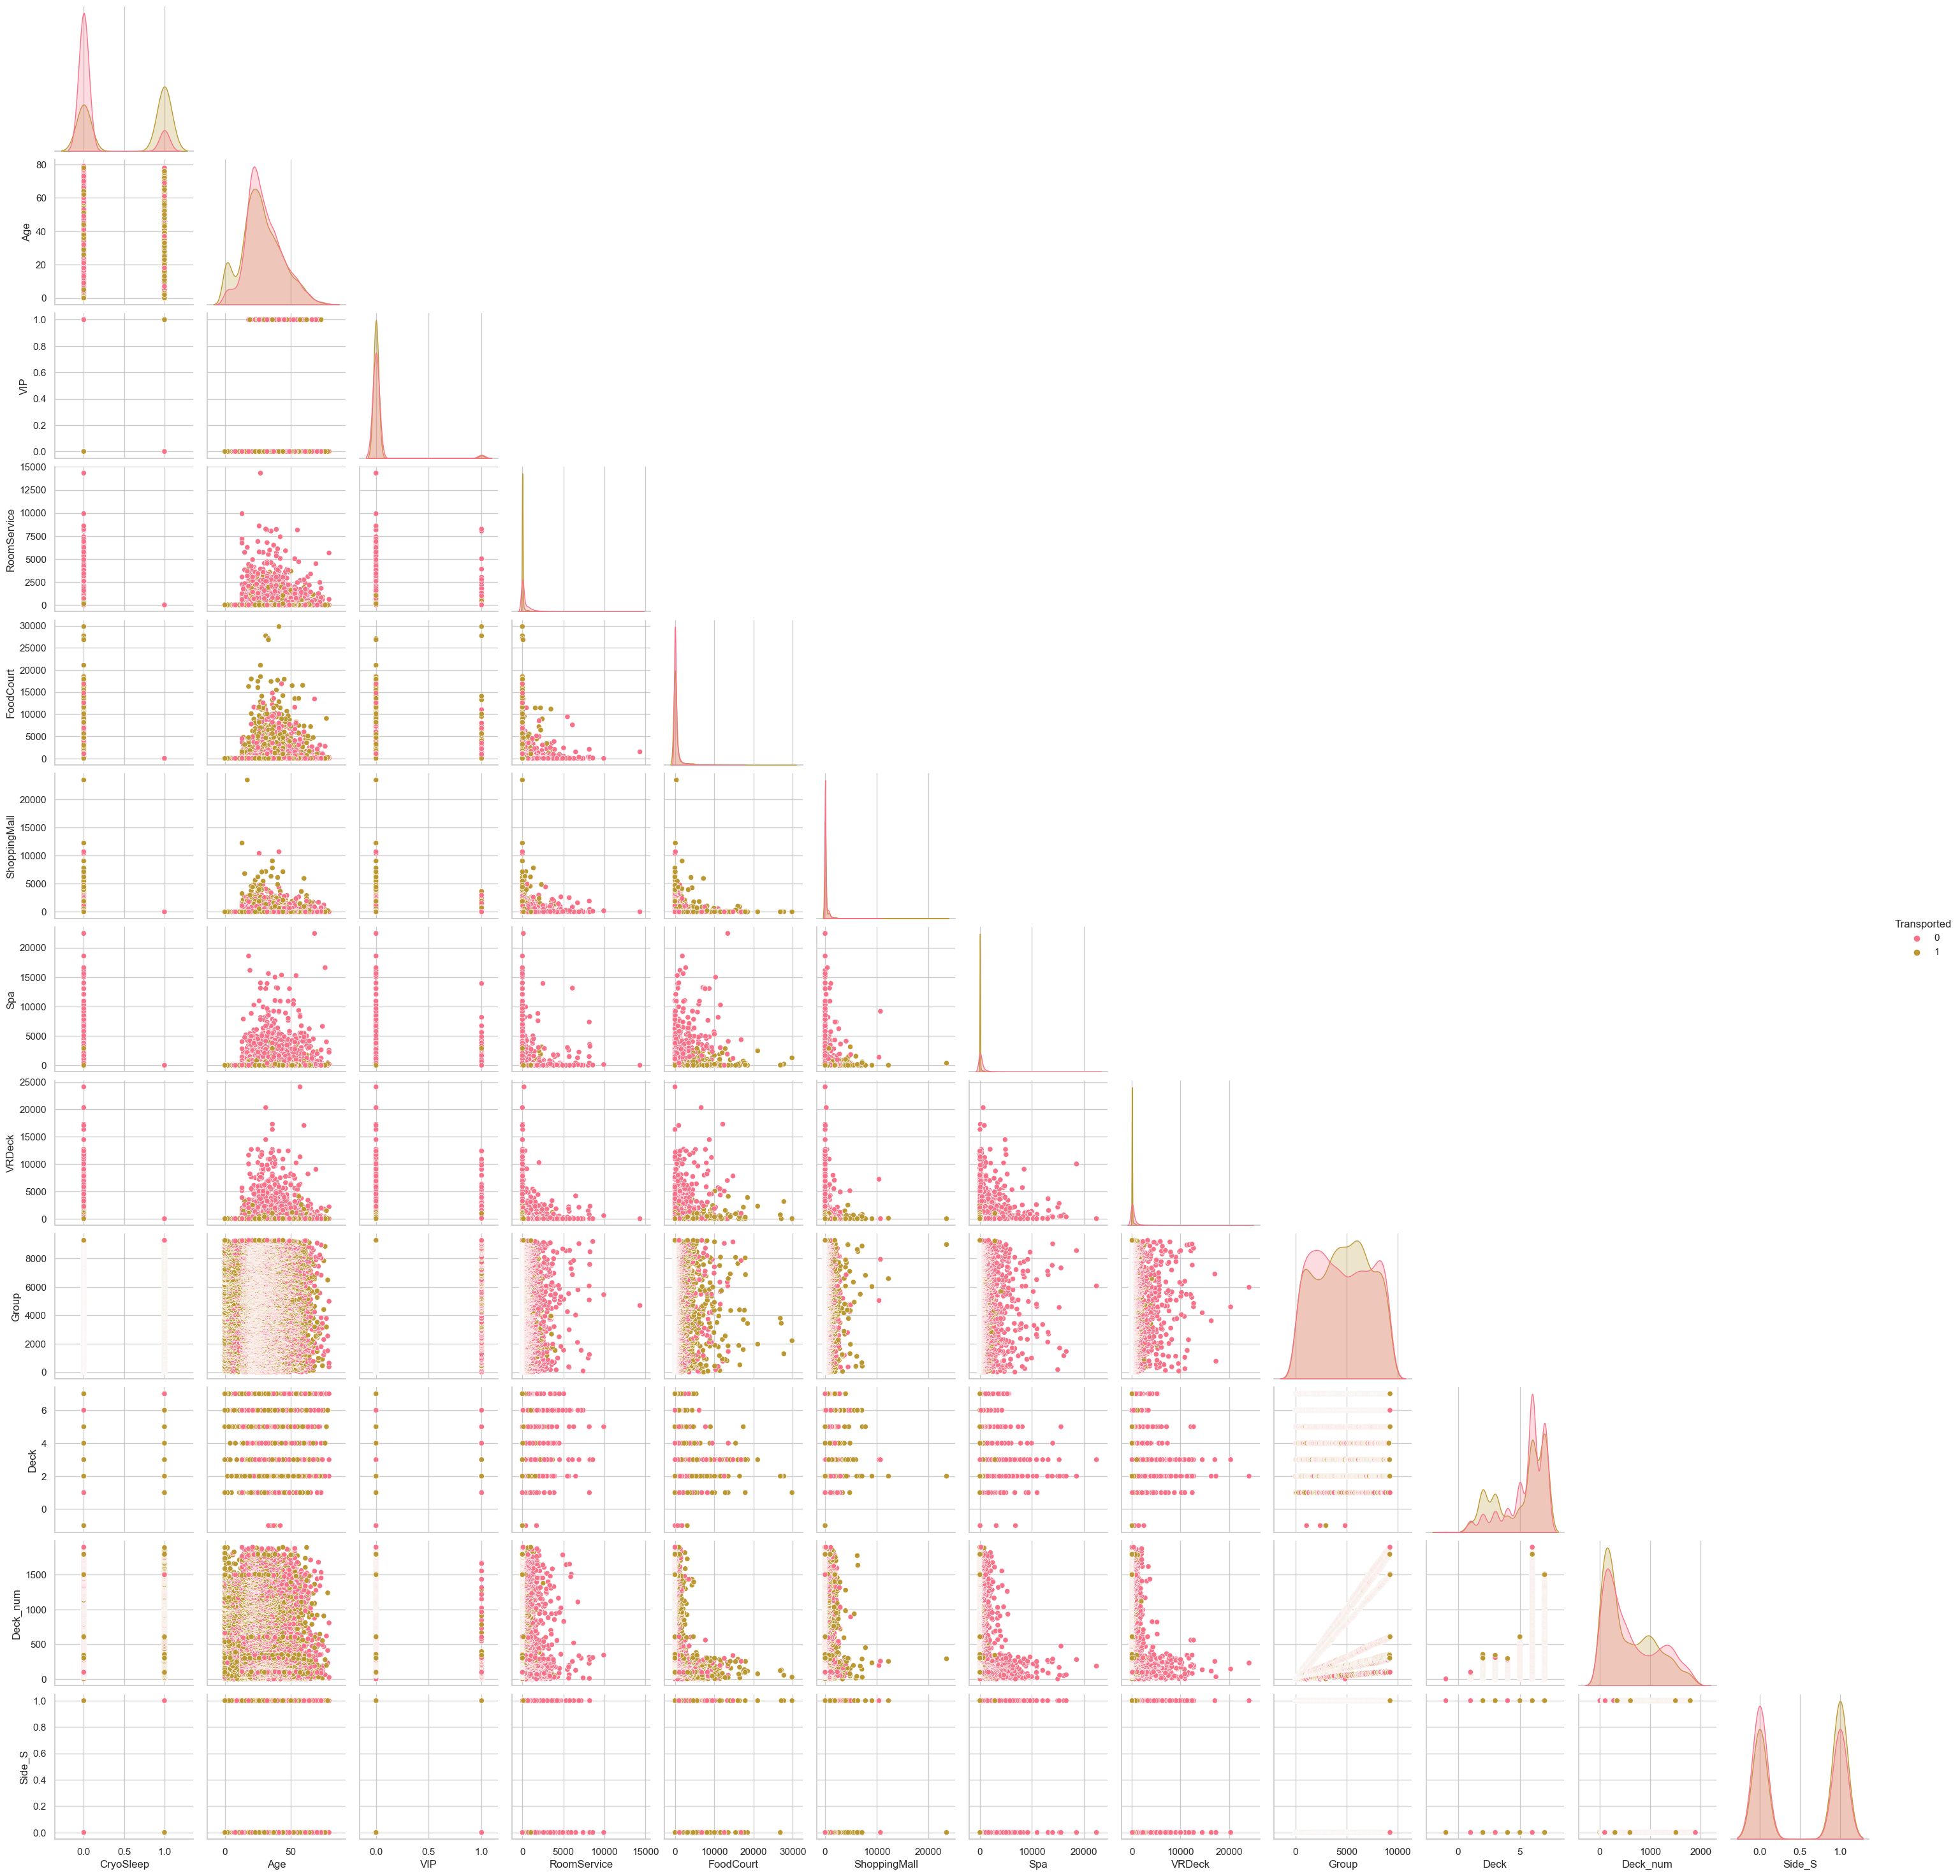

In [47]:
sns.pairplot(titanic.drop(columns=['Cabin', 'First_Name', 'Last_Name', 'Group_Id']), corner=True, hue='Transported')
plt.show()

## Continues features
Continues features are made of:
* Amenities in Spaceship which are log tranformed to make the data normaly distributed
* Age - which ranges 0-79 years. With median mid 20s. Outliers are above ~65, but it's not uncommon for people up to 80 to travel and these will be left in.
* Group 
* Deck_num

In [51]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
continuous_features = ['Age', 'Group', 'Deck_num'] + amenities

In [49]:
titanic_log = titanic.copy()

# Updating spent amount to -1, when spent was 0 (for log transformation to work)
titanic_log[amenities] = titanic_log[amenities].replace({0:-1})
titanic_log[amenities] = titanic_log[amenities].apply(np.log)

Age


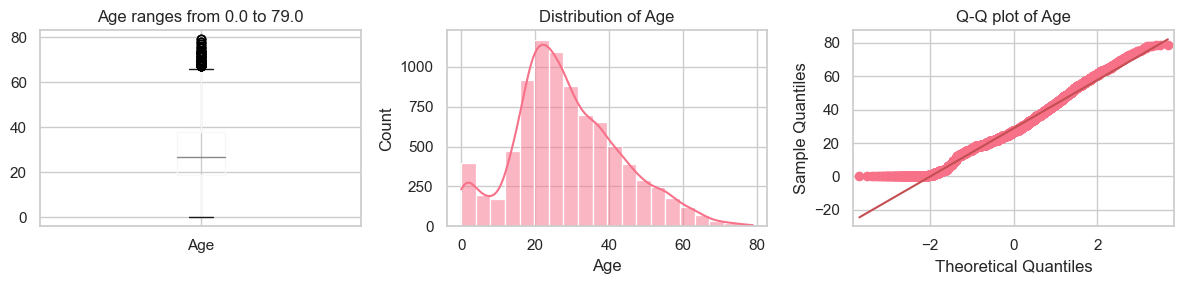

Group


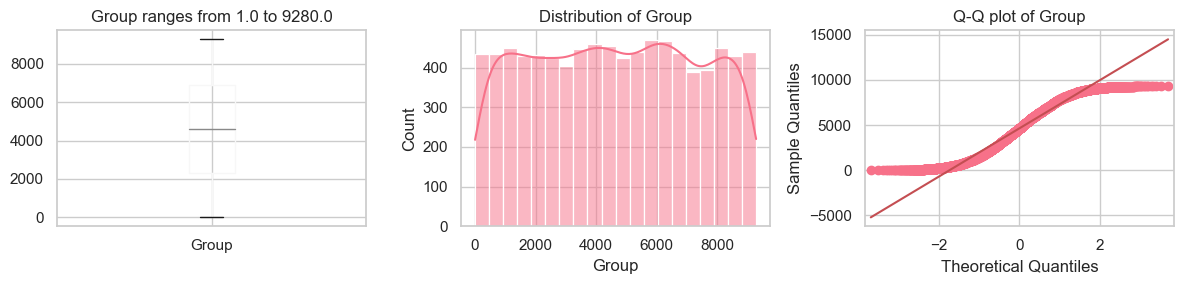

Deck_num


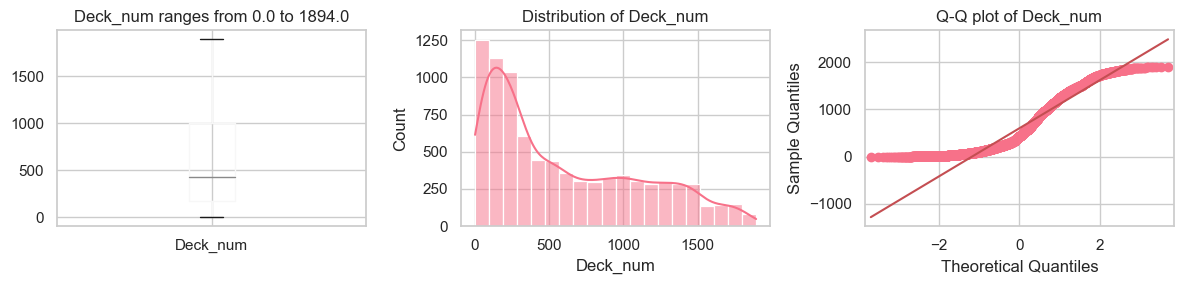

RoomService


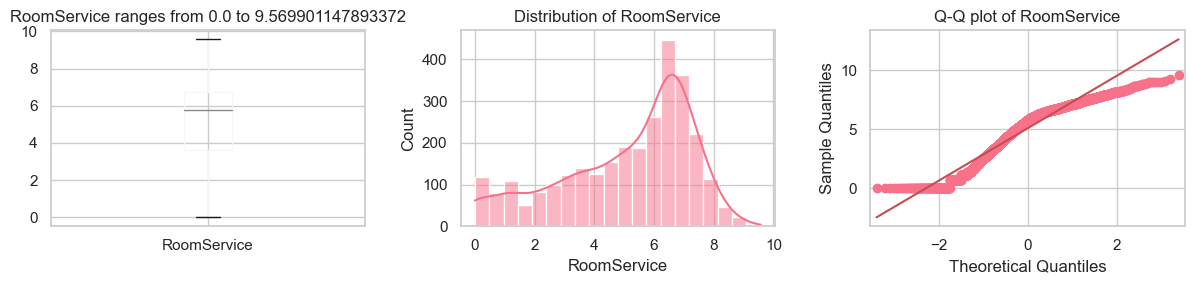

FoodCourt


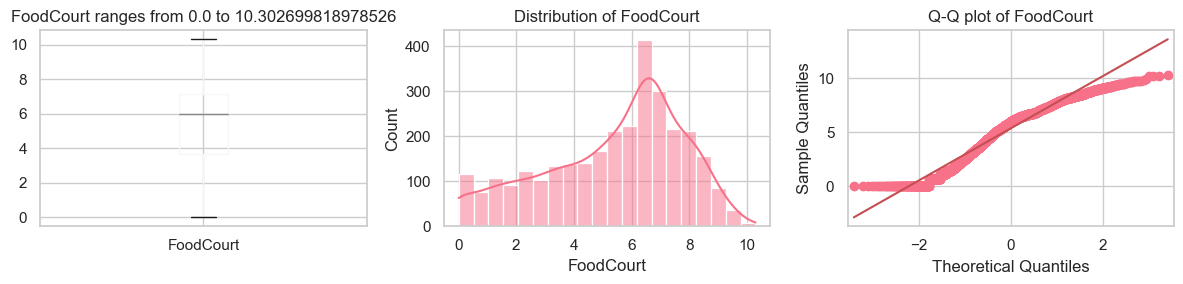

ShoppingMall


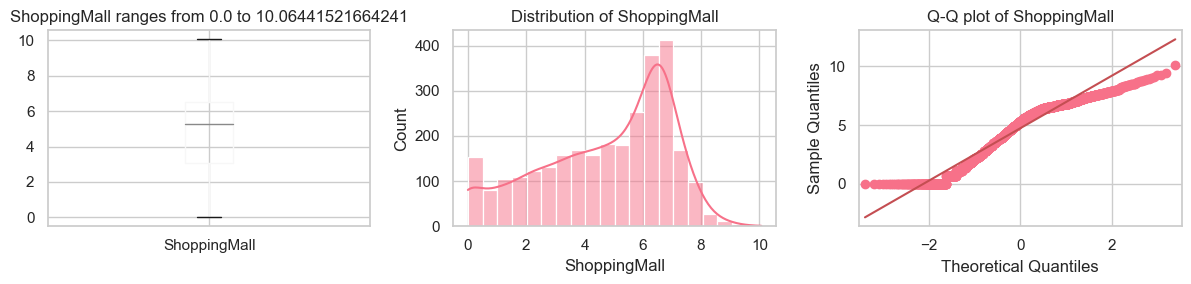

Spa


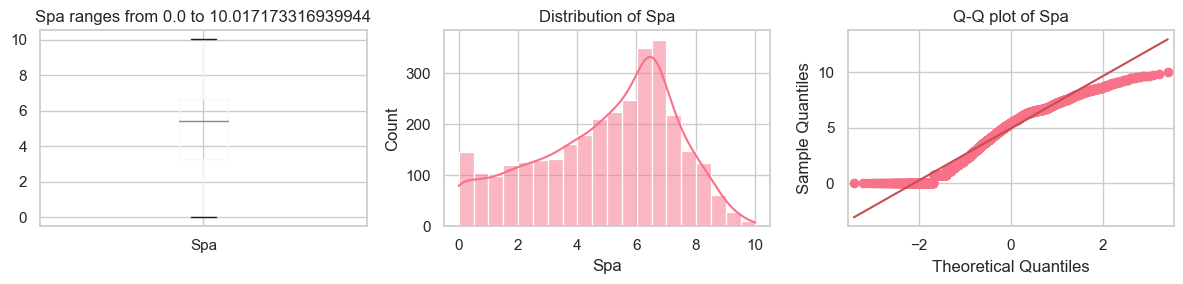

VRDeck


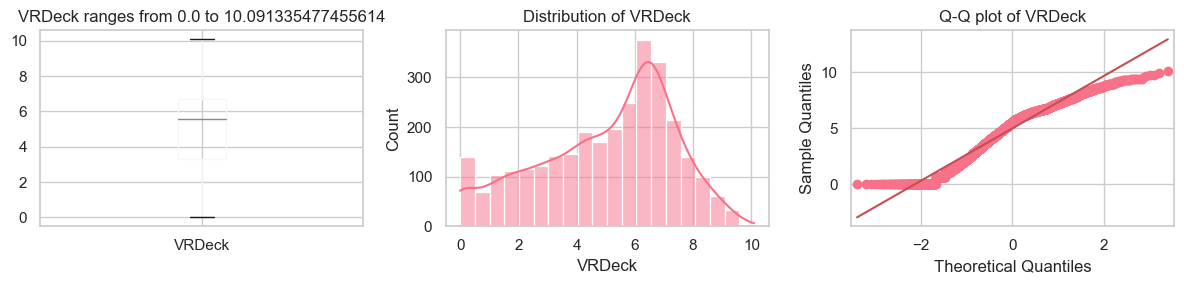

In [12]:
help_tool.distribution_check(titanic_log[continuous_features])

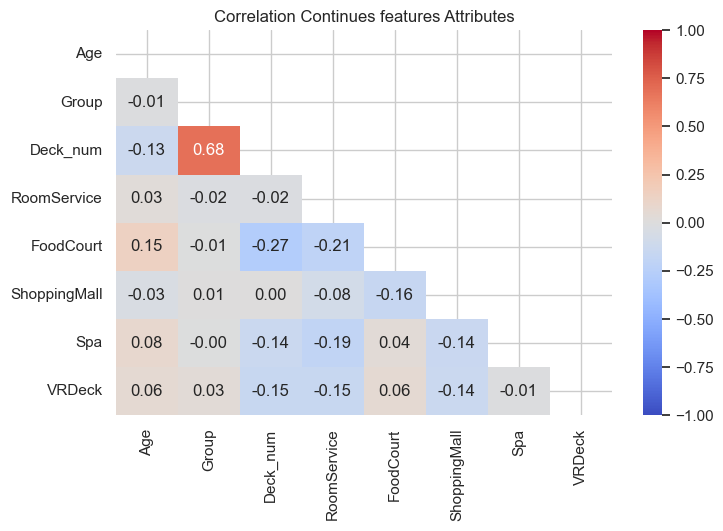

In [13]:
help_tool.heatmap(titanic_log[continuous_features], 'Continues features', 'pearson')

* No feature pairs with strong positive or negative correlation (+/- 1)
* Deck_num and Group has moderate (0.5-0.75) correlation. Groups must be assigned to based on Deck_num, Side and Deck. 
* Group is pats of passanger identification and will not be used in model training.

<Figure size 1200x800 with 0 Axes>

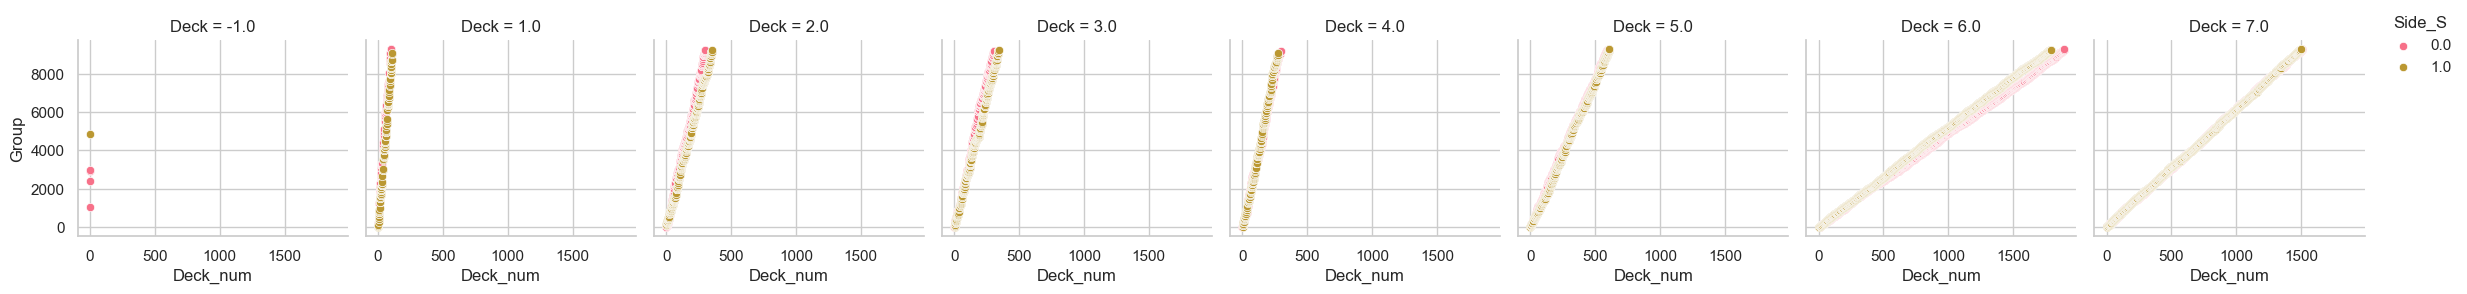

In [56]:
plt.figure(figsize=(12, 8)) 

g = sns.FacetGrid(titanic_log, col="Deck", hue='Side_S')

g.map(sns.scatterplot, "Deck_num", "Group")
g.add_legend(title='Side_S', loc='upper right', bbox_to_anchor=(1, 1))

plt.show()

## Categorical features
* Target feature Transported seams balanced


In [15]:
category_features = ['HomePlanet', 'Destination', 'Deck', 'Group_Id']
binary_features = ['CryoSleep', 'VIP', 'Transported', 'Side_S']

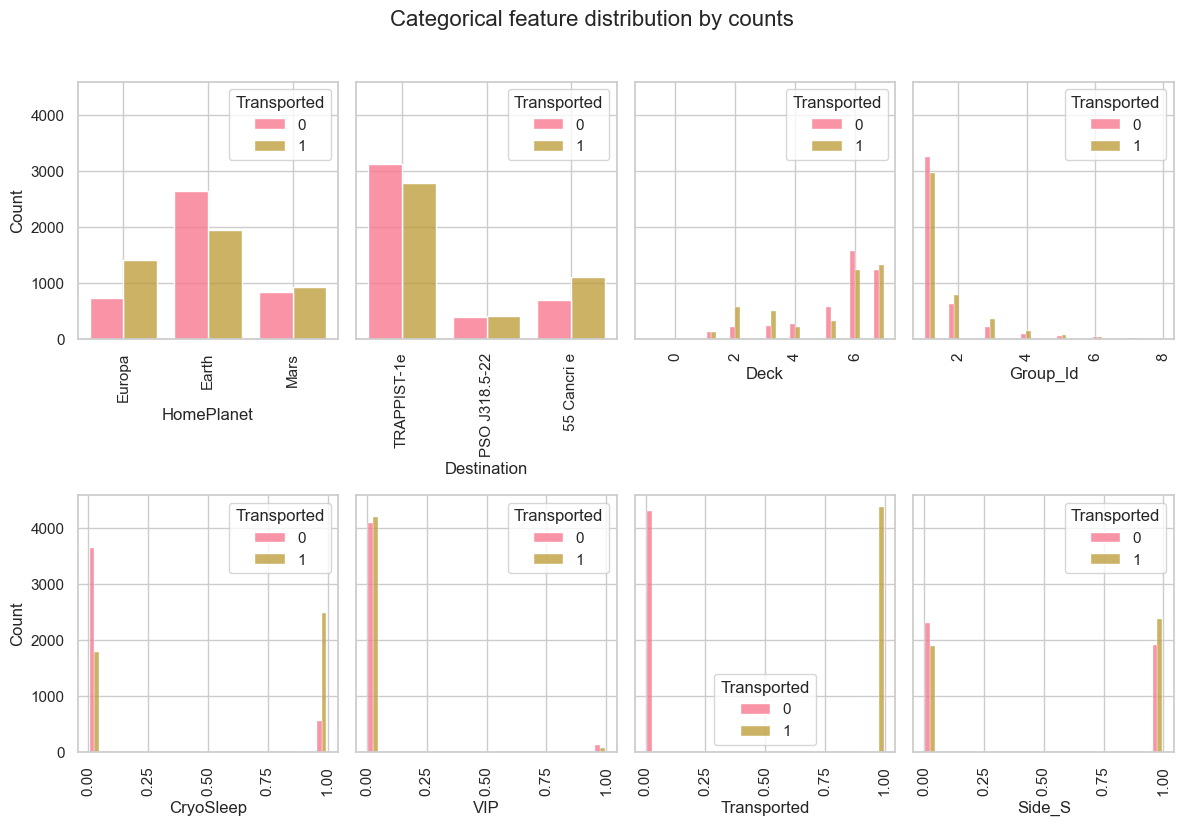

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8), sharey=True)

axes = axes.flatten()

for i, col in enumerate(category_features + binary_features):
    sns.histplot(data=titanic_log, x=col, bins=20, multiple="dodge", shrink=.8, 
                 ax=axes[i], hue='Transported', legend=True)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

Binary features are not correlated to eachother, but CryoSleep and Transported is somewhat correlated.

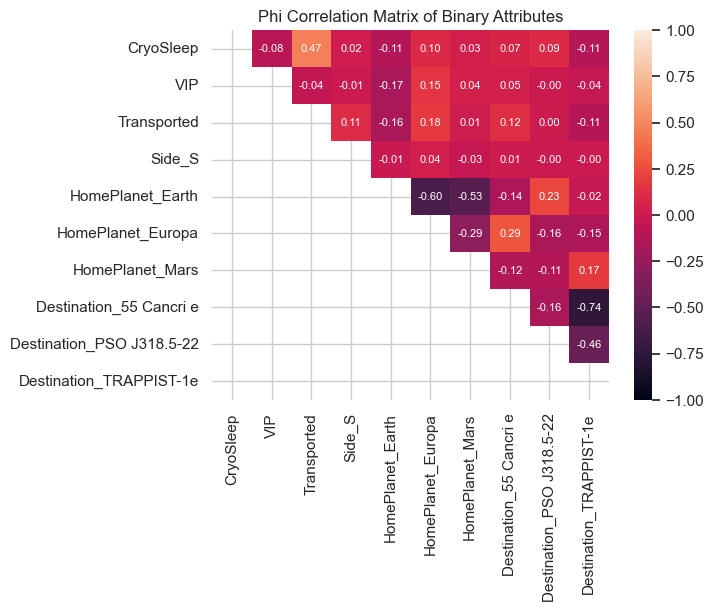

In [57]:
titanic_dummies = help_tool.dummy_columns(
    titanic, ['HomePlanet', 'Destination'])


dummy_features = ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e']

titanic_dummies.dropna(inplace=True)

help_tool.phi_corr_matrix(titanic_dummies, binary_features+dummy_features)

# Categorical vs Continues features

In [61]:
titanic[titanic['CryoSleep'] == 1][amenities].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

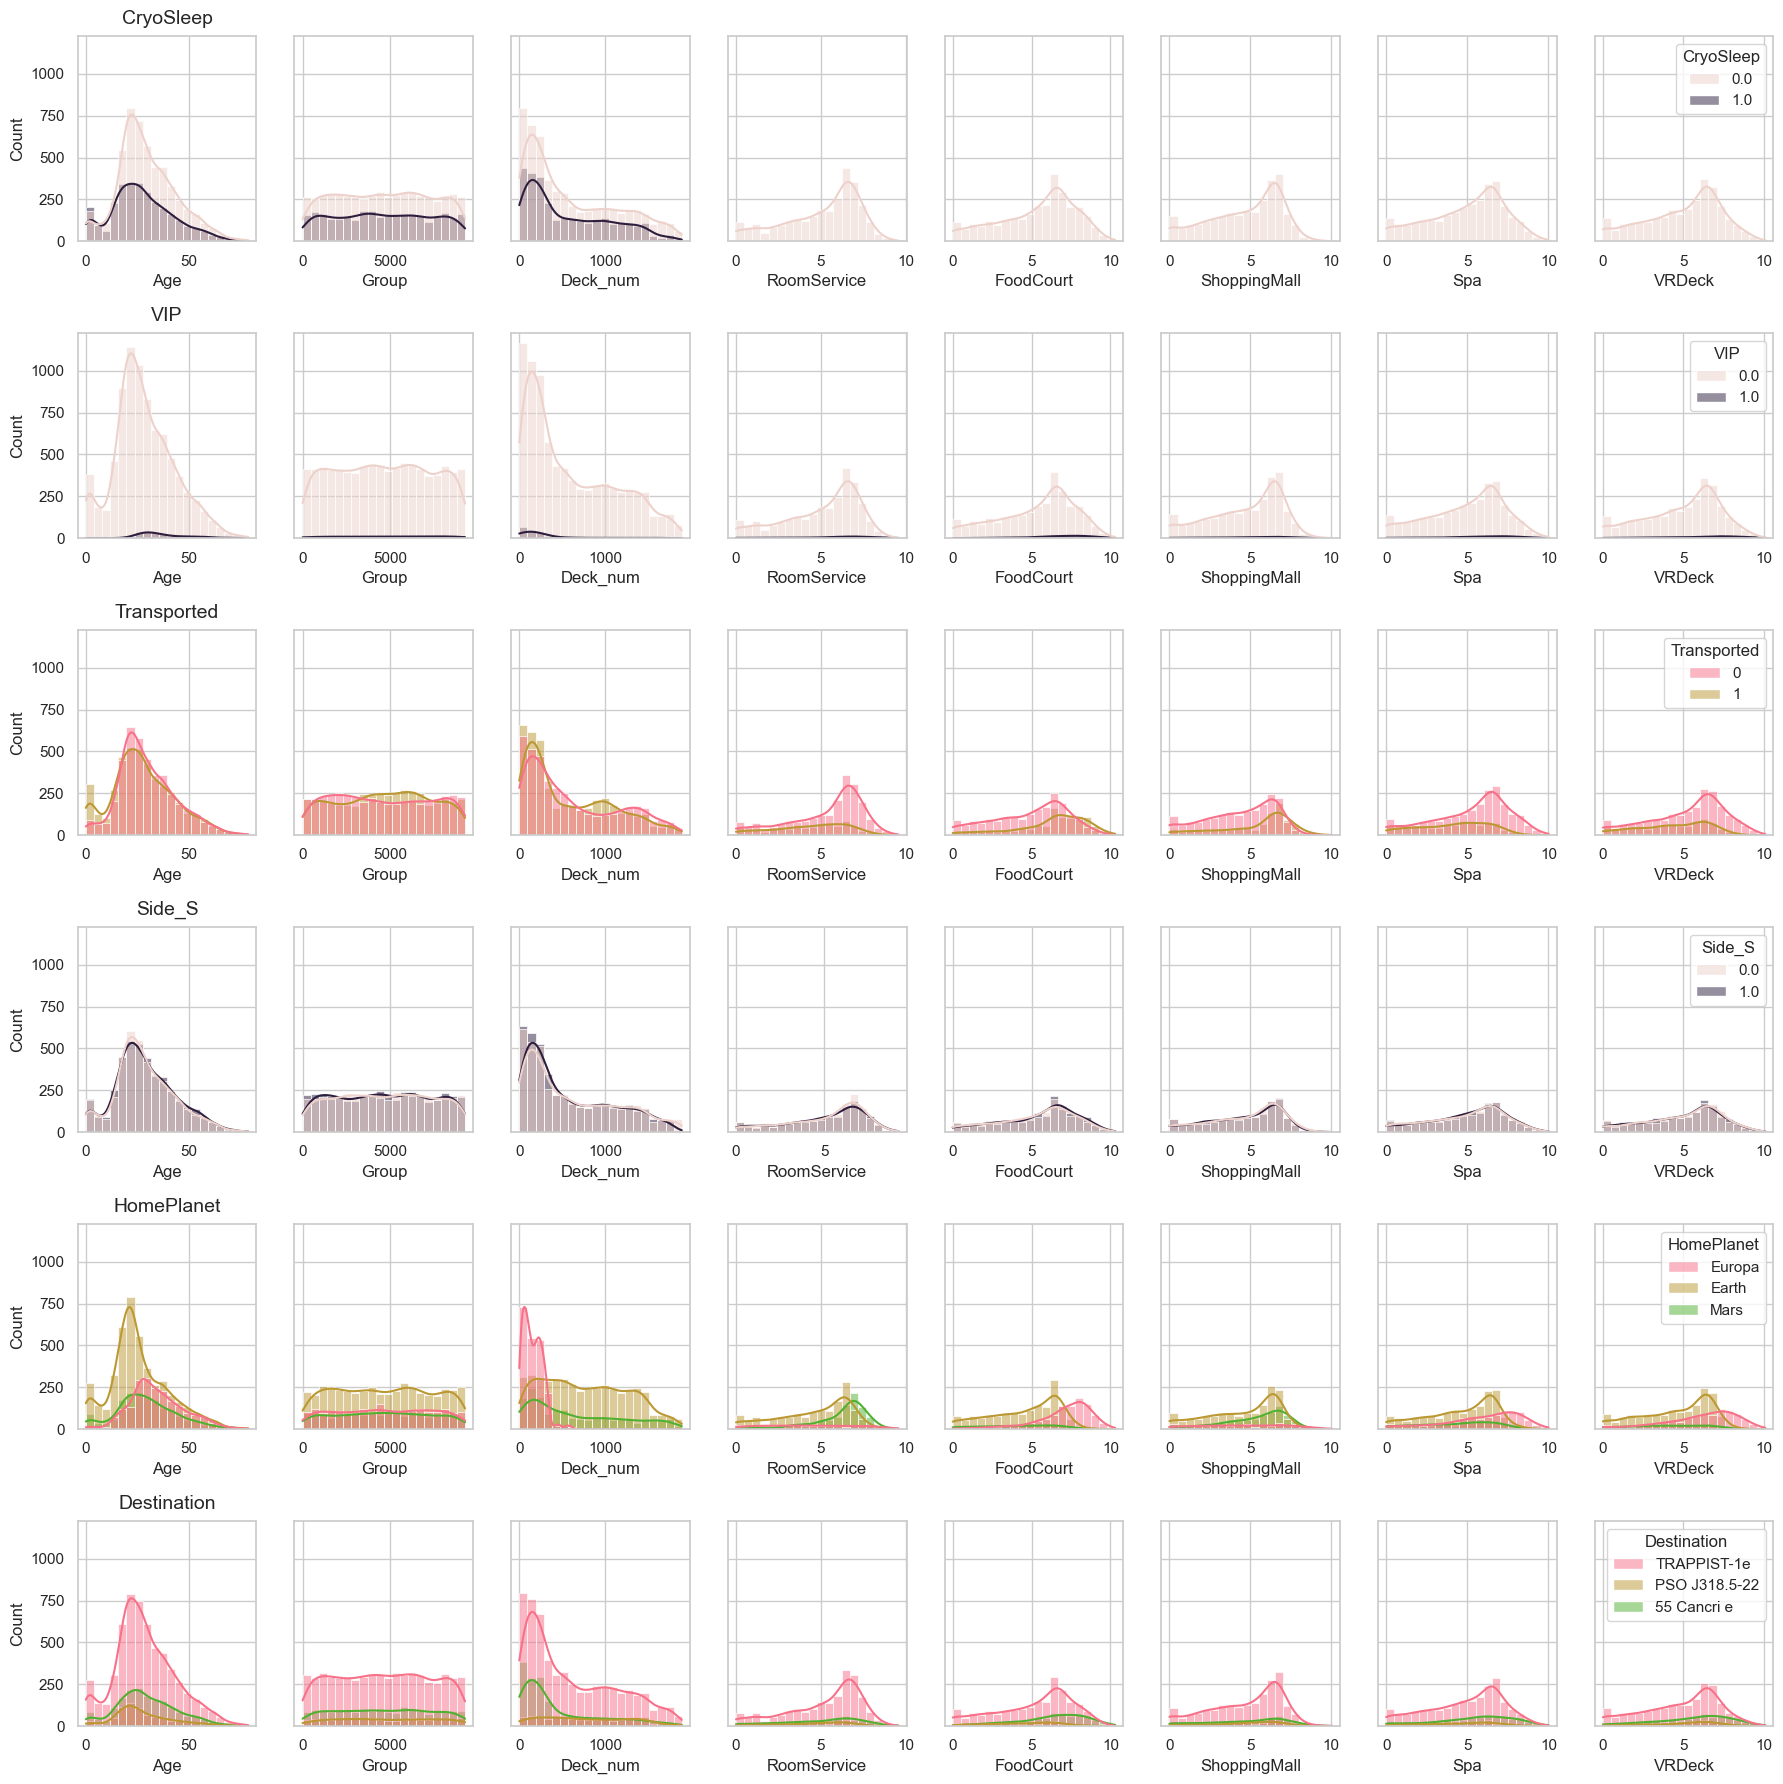

In [18]:
fig, axes = plt.subplots(6, 8, figsize=(18, 18), sharey=True)  

for i, col in enumerate(continuous_features):
    for j, hue_var in enumerate(binary_features + ['HomePlanet', 'Destination']):
        legend = False if (i+1) % 8 != 0 else True
        sns.histplot(data=titanic_log, x=col, kde=True, bins=20, ax=axes[j, i], hue=hue_var, legend=legend)
        if i % 8 == 0:
            axes[j, i].set_title(f"{hue_var}", size=14, y=1.02)

plt.tight_layout()
plt.show()

In [19]:
from scipy import stats

In [20]:
titanic_log.dropna(inplace=True)

In [21]:
binary_features = ['CryoSleep', 'VIP', 'Transported', 'Side_S']
continuous_features = ['Age',
 'Group',
 'Deck_num',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\scipy\stats\_stats_py.py:5546: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


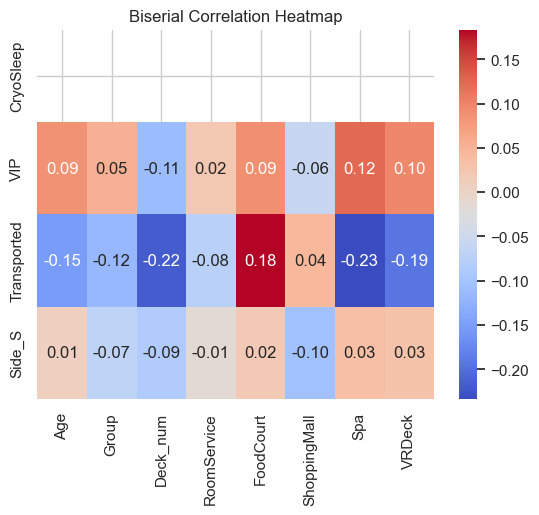

In [22]:
correlation_matrix = pd.DataFrame(index=binary_features, columns=continuous_features)

# Calculate biserial correlations and fill the matrix
for binary_feature in binary_features:
    for continuous_feature in continuous_features:
        biserial_corr, _ = stats.pointbiserialr(titanic_log[binary_feature], titanic_log[continuous_feature])
        correlation_matrix.loc[binary_feature, continuous_feature] = biserial_corr

# Convert the matrix to numeric values
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Biserial Correlation Heatmap")
plt.show()

## Deck, homeplanet and destination
Homeplanet determines deck living area:
* Eurompa: 1-5
* Earth: 5-7
* Mars: 4-6

Homeplanet should not be used in modeling as it can be derived from another column

<Figure size 1200x800 with 0 Axes>

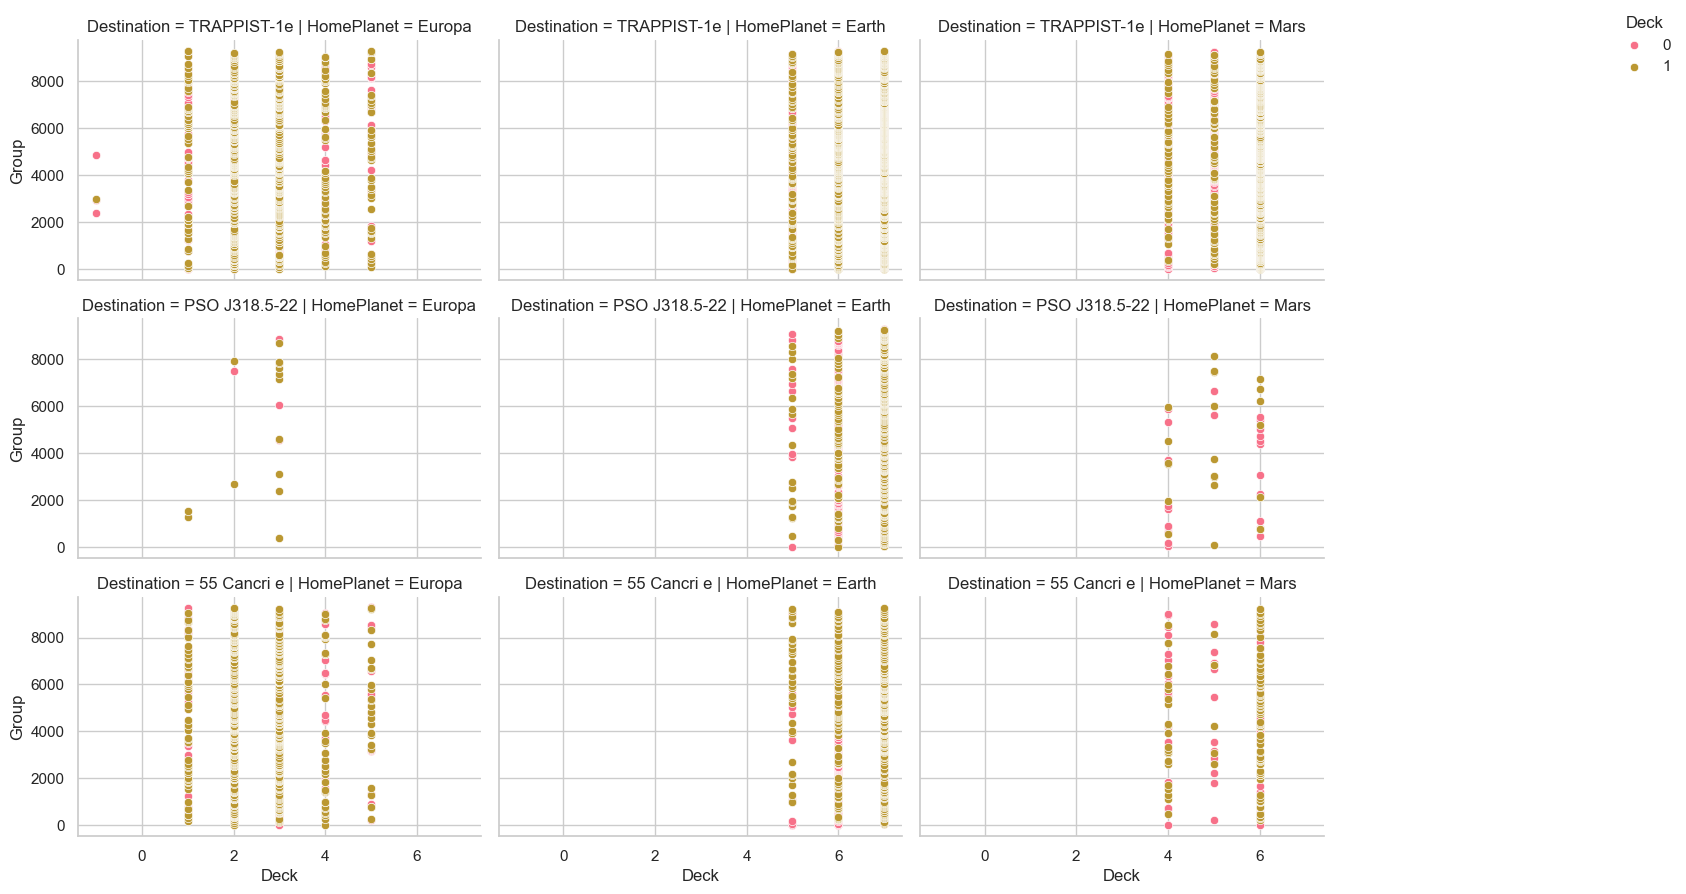

In [23]:
plt.figure(figsize=(12, 8)) 

g = sns.FacetGrid(titanic, row="Destination", col="HomePlanet", hue='Transported', height=3, aspect=1.5)

g.map(sns.scatterplot, "Deck", "Group")

g.add_legend(title='Deck', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

# Mutual information gain

In [24]:
from sklearn.feature_selection import mutual_info_classif

In [25]:
titanic.columns


Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Group', 'Group_Id', 'Deck', 'Deck_num', 'Side_S',
       'First_Name', 'Last_Name'],
      dtype='object')

c:\Users\Gintare\Desktop\Study\Module3\Sprint3\New_code\Spaceship_Titanic\help_tool\help_tool.py:101: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method=method)


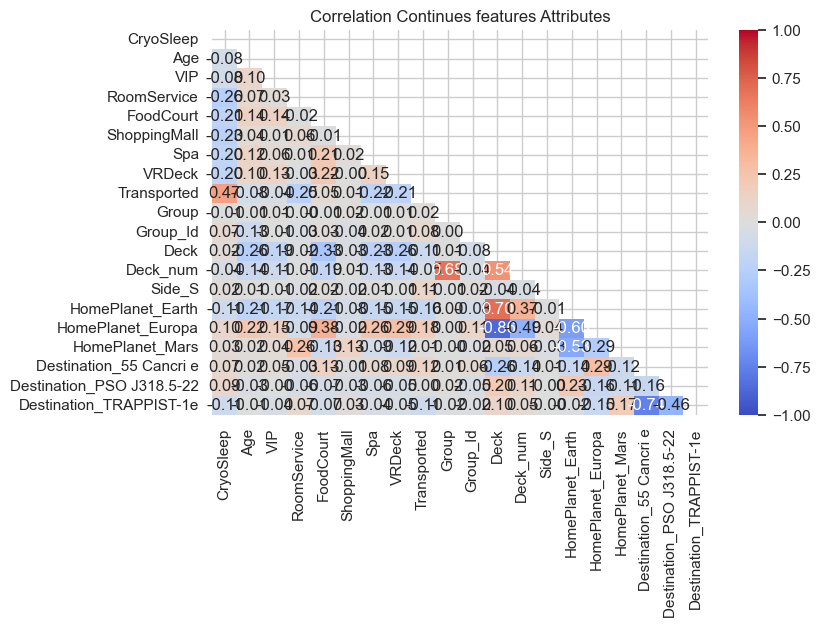

In [26]:
help_tool.heatmap(titanic_dummies,
                  'Continues Features', 'pearson')

In [27]:
titanic_dummies = help_tool.dummy_columns(
    titanic, ['HomePlanet', 'Destination'])

In [28]:
titanic.shape

(8693, 19)

In [29]:
titanic_dummies.dropna(inplace=True)
titanic_dummies.shape

(6918, 23)

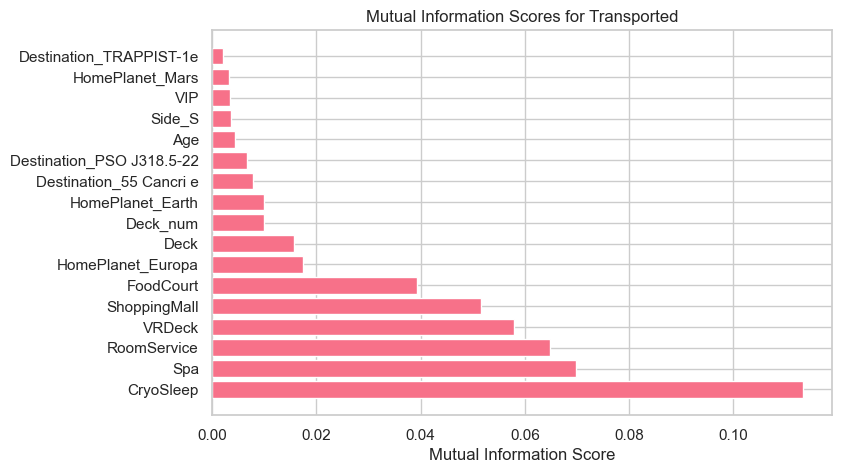

In [30]:
X = titanic_dummies.drop(['Transported', 'Cabin', 'Group', 'Group_Id', 'First_Name', 'Last_Name'], axis=1)
y = titanic_dummies['Transported']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(
    X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain',
                      ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Transported")
plt.show()

stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

# Scalling 0 to 1, as KNN is sensitive to neighbor distince

stroke_data_dummies['Age_rescaled'] = stroke_data_dummies['Age']/100

stroke_data_dummies['Avg_glucose_level_rescaled'] = stroke_data_dummies['Avg_glucose_level']/300

stroke_data_dummies['Bmi_rescaled'] = stroke_data_dummies['Bmi']/100


# Removing non-scalled features

def_imputation = stroke_data_dummies.drop(
    ['Bmi', 'Avg_glucose_level', 'Age', 'Bmi_was_missing', 'Smoking_status_was_missing'], axis=1)



# KNNImputer for NaN values

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer.fit(def_imputation)

imputed_features = imputer.transform(def_imputation)

imputed_df = pd.DataFrame(imputed_features, columns=def_imputation.columns)



# Rescalling back BMI

imputed_df['Age'] = imputed_df['Age_rescaled']*100

imputed_df['Avg_glucose_level'] = imputed_df['Avg_glucose_level_rescaled']*300

imputed_df['Bmi'] = imputed_df['Bmi_rescaled']*100

stroke_data_dummies = imputed_df.drop(
    ['Age_rescaled', 'Avg_glucose_level_rescaled', 'Bmi_rescaled'], axis=1)

# Reseting indexes as they got uneven after imputation
imputed_df.reset_index(drop=True, inplace=True)
stroke_data.reset_index(drop=True, inplace=True)

# Assigning new values
stroke_data['Bmi'] = imputed_df['Bmi']
stroke_data['Smoking_status'] = imputed_df['Smoking_status'].round().astype(int)

# Rewriting stroke_data_dummies to fit the new structure
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])